# Bibliotecas

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay, brier_score_loss
)
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import optuna
from functools import partial

# Extração dos dados

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/xG/"

X_train = pd.read_csv(path + "X_train_.csv")
X_test  = pd.read_csv(path + "X_test_.csv")
y_train = pd.read_csv(path + "y_train.csv").values.ravel()
y_test  = pd.read_csv(path + "y_test.csv").values.ravel()
xg = pd.read_csv(path + 'X_baseline.csv')
xg_baseline = xg.loc[X_test.index]
xg_baseline = xg_baseline['shot_statsbomb_xg'].values

# Funções auxiliares

In [ ]:
def result(X_test, model):

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    brier = brier_score_loss(y_test, y_prob)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nBrier Score: ", round(brier, 4))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("Curva ROC")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(y_prob, color='blue', label='Regressão Logística (xG)', kde=True, stat='density', linewidth=0)
    sns.histplot(xg_baseline, color='red', label='StatsBomb (xG)', kde=True, stat='density', linewidth=0)
    plt.title('Distribuição de Probabilidades Previstas (Teste)')
    plt.xlabel('Probabilidade Prevista (xG)')
    plt.legend()
    plt.show()

    plt.hist(y_prob, bins=100)
    plt.show()

    print("Min", np.min(y_prob))
    print("Max", np.max(y_prob))
    print("Mean", np.mean(y_prob))

In [ ]:
def objective(trial, metric: str = "accuracy", pca_method: bool = False):

    # Hiperparâmetros que o Optuna vai testar
    C = trial.suggest_float("C", 1e-5, 1e5, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "newton-cg", "lbfgs", "sag", "saga"])
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    tol = trial.suggest_float("tol", 1e-5, 1e-2)

    # Garantir que a penalidade seja compatível com o solver
    if solver == "lbfgs" and penalty == "l1":
        penalty = "l2"  # Ajusta para l2, que é compatível com lbfgs
    elif solver == "newton-cg" and penalty == "l1":
        penalty = "l2"  # Ajusta para l2, que é compatível com newton-cg
    elif solver == "newton-cg" and penalty == "elasticnet":
        penalty = "l2"  # Ajusta para l2, que é compatível com newton-cg
    elif solver == "liblinear" and penalty == "elasticnet":
        penalty = "l2"  # Ajusta para l2, que é compatível com liblinear

    # Criar o modelo de regressão logística
    model = LogisticRegression(
        C=C,
        solver=solver,
        max_iter=max_iter,
        penalty=penalty,
        tol=tol,
        random_state=42
    )

    metric_value = 0

    if pca_method:

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", model)
        ])

        # Normalização dos dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Definir o número de componentes a ser testado pelo Optuna
        n_components = trial.suggest_int("n_components", 1, X_train_scaled.shape[1])

        # Aplicar PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Treinar o modelo
        pipeline.fit(X_train_pca, y_train)

        y_pred = pipeline.predict(X_test_pca)
        y_prob = pipeline.predict_proba(X_test_pca)[:, 1]

        # Avaliar a métrica
        if metric == "accuracy":
            metric_value = accuracy_score(y_test, y_pred)
        elif metric == "auc":
            metric_value = roc_auc_score(y_test, y_prob)
        elif metric == "recall":
            metric_value = recall_score(y_test, y_pred)
        elif metric == "brier_score":
            metric_value = brier_score_loss(y_test, y_prob)

    else:

        pipeline = Pipeline([
            ("logreg", model)
        ])
        # Treinar o modelo sem PCA
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Avaliar a métrica
        if metric == "accuracy":
            metric_value = accuracy_score(y_test, y_pred)
        elif metric == "auc":
            metric_value = roc_auc_score(y_test, y_prob)
        elif metric == "recall":
            metric_value = recall_score(y_test, y_pred)
        elif metric == "brier_score":
            metric_value = brier_score_loss(y_test, y_prob)

    return metric_value


# Treinamento 1 - Modelo base

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.68      0.28      0.39       167

    accuracy                           0.91      1567
   macro avg       0.80      0.63      0.67      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0745


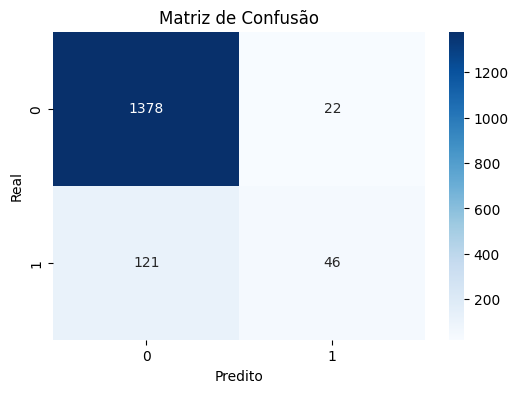

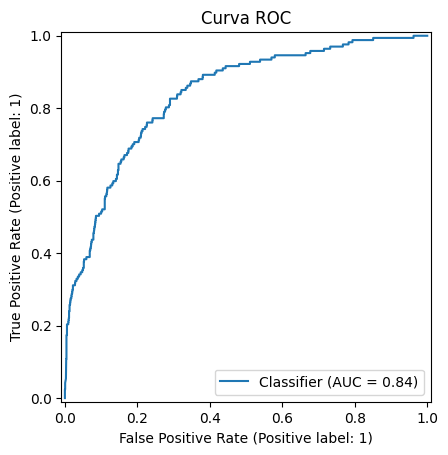

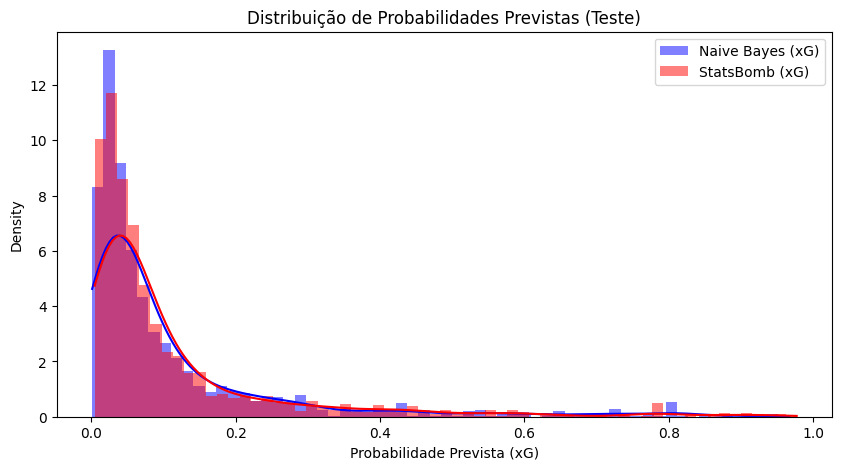

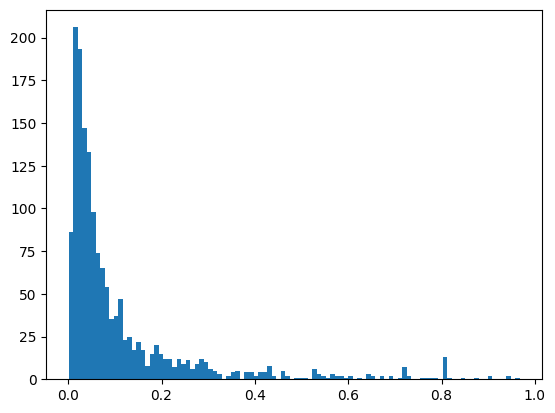

Min 0.0008792441340414966
Max 0.9672275096643175
Mean 0.1103650861928491


In [ ]:
result(X_test, model)

# Treinamento 2 - Modelo Base + PCA

## PCA

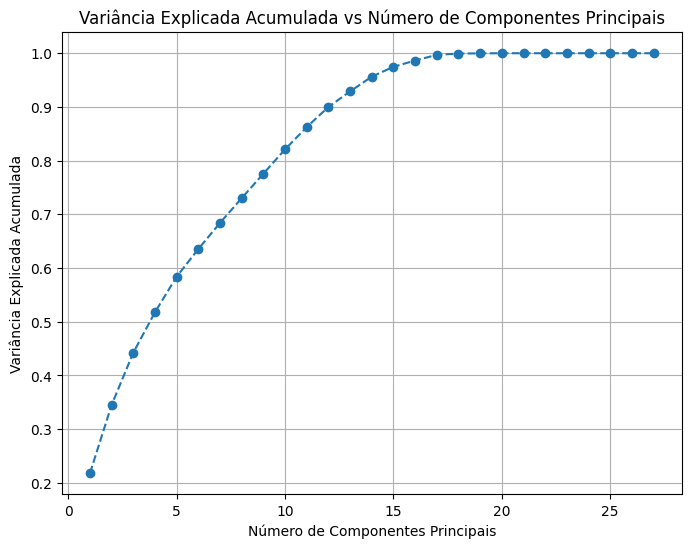

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar o PCA
pca = PCA()
pca.fit(X_train_scaled)

# Plotar a variância explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, X_train_scaled.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada vs Número de Componentes Principais')
plt.grid(True)
plt.show()

## 2 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.78      0.17      0.28       167

    accuracy                           0.91      1567
   macro avg       0.85      0.58      0.62      1567
weighted avg       0.90      0.91      0.88      1567


Brier Score:  0.0797


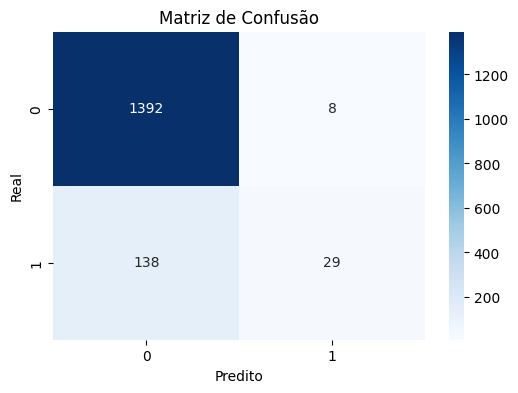

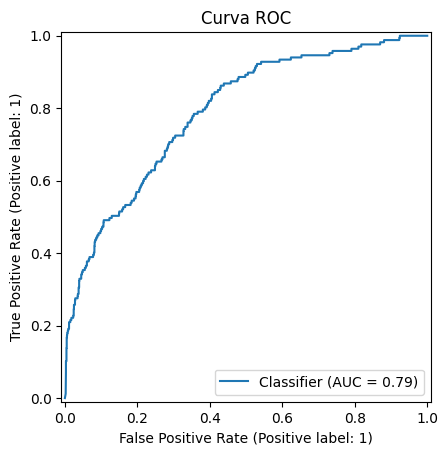

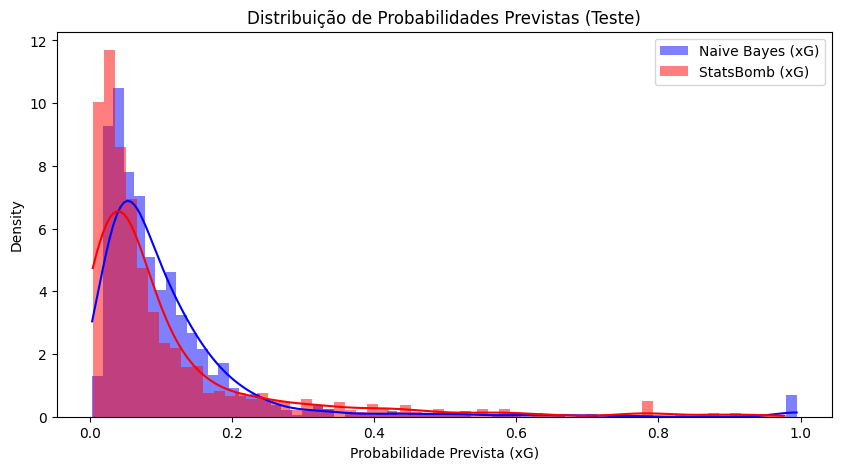

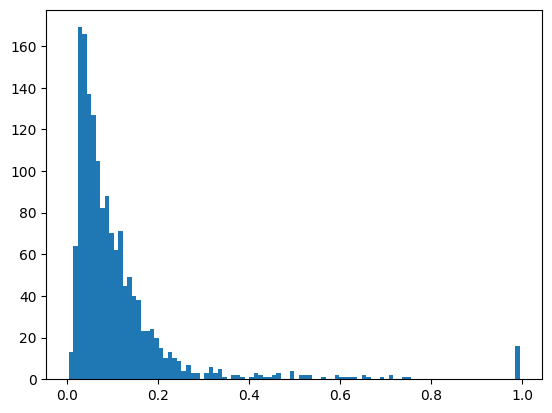

Min 0.0035096285474901733
Max 0.99442234508314
Mean 0.10954611627829944


In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 5 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.73      0.18      0.29       167

    accuracy                           0.91      1567
   macro avg       0.82      0.59      0.62      1567
weighted avg       0.89      0.91      0.88      1567


Brier Score:  0.0765


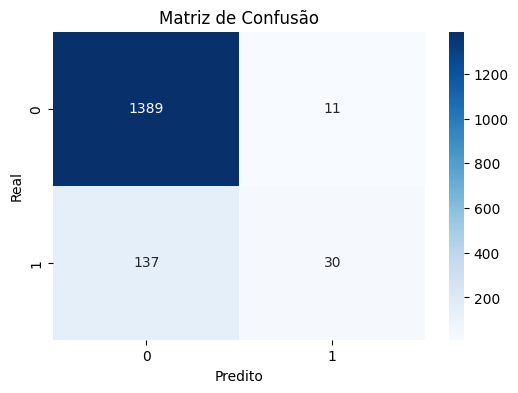

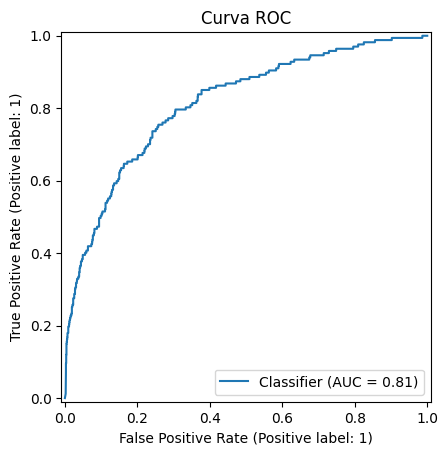

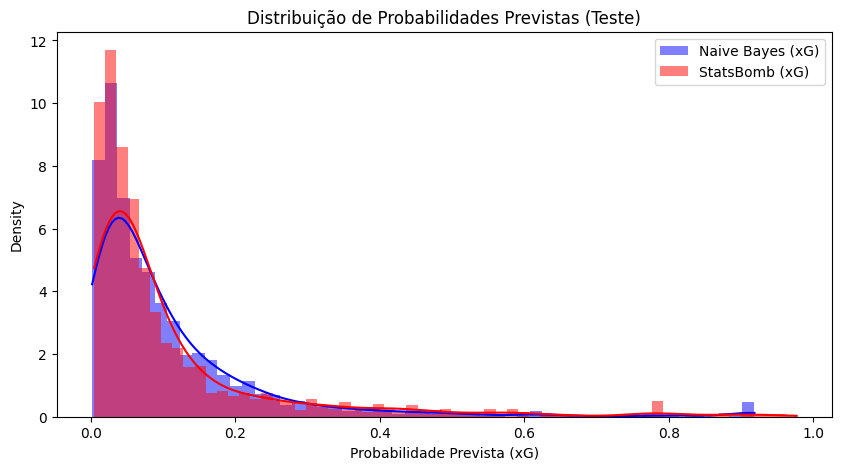

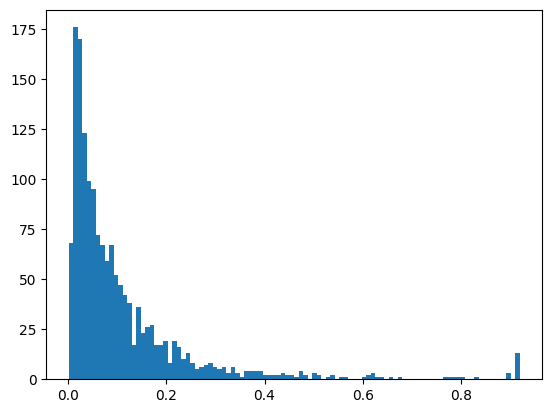

Min 0.0015404490404909445
Max 0.9187508114600315
Mean 0.10875066464224985


In [ ]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 7 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.71      0.18      0.29       167

    accuracy                           0.90      1567
   macro avg       0.81      0.59      0.62      1567
weighted avg       0.89      0.90      0.88      1567


Brier Score:  0.0766


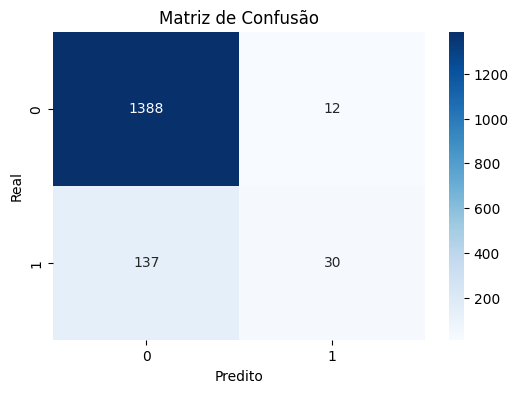

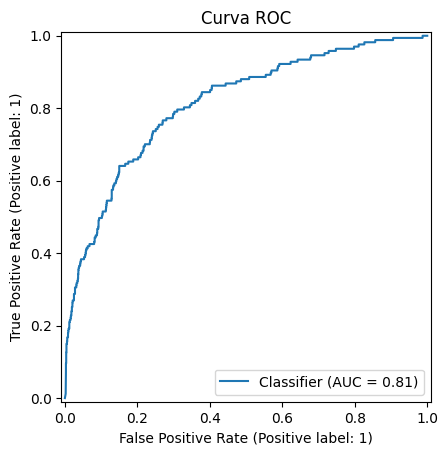

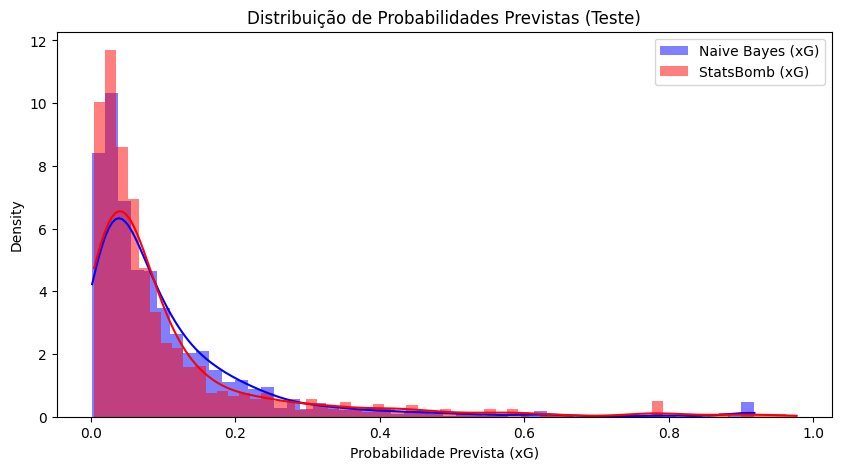

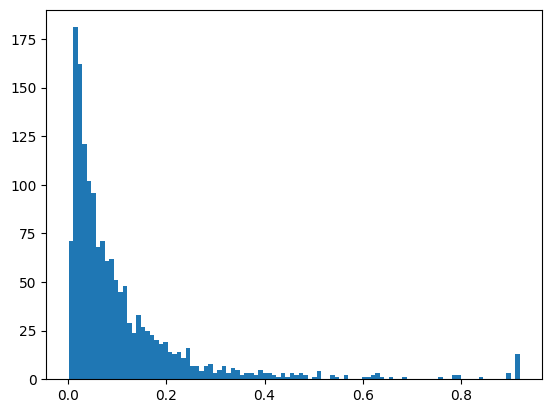

Min 0.0015126194005540543
Max 0.9186881023449249
Mean 0.10880860905682335


In [ ]:
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 10 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.73      0.18      0.29       167

    accuracy                           0.91      1567
   macro avg       0.82      0.59      0.62      1567
weighted avg       0.89      0.91      0.88      1567


Brier Score:  0.0765


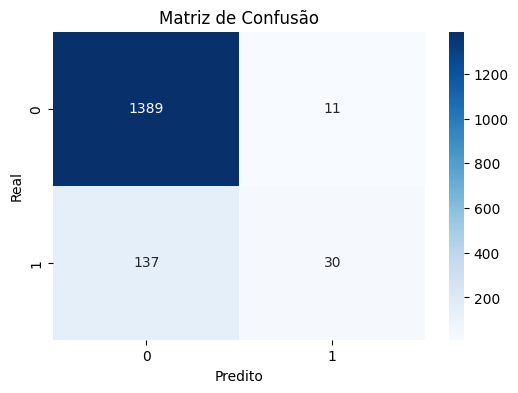

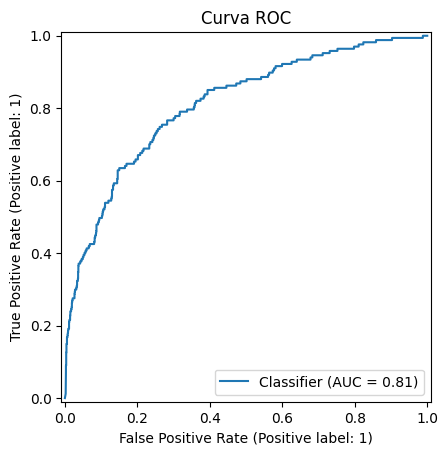

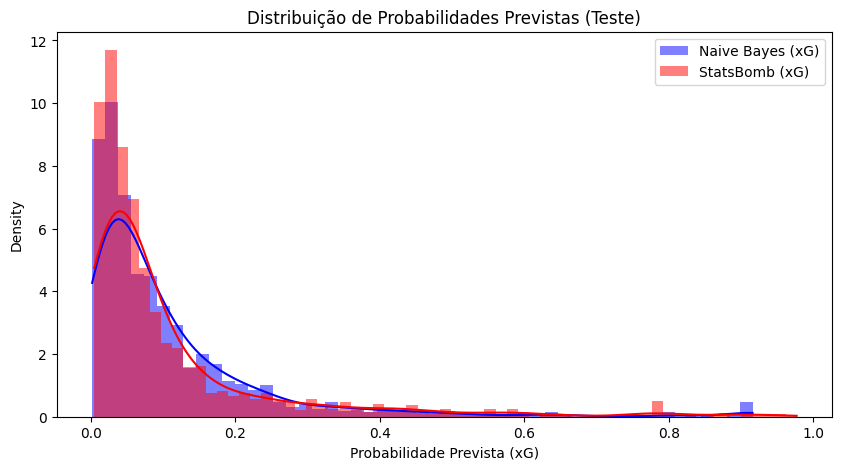

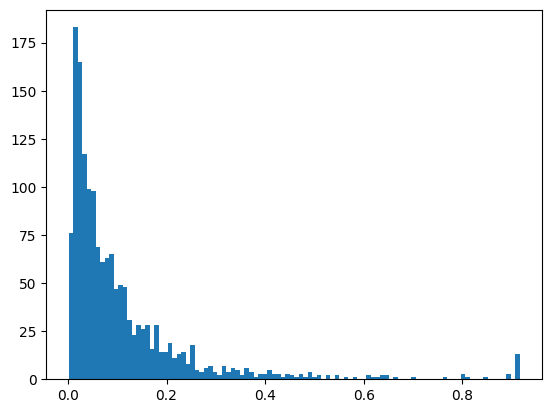

Min 0.0014384267055689995
Max 0.9161151142844423
Mean 0.10916189742421302


In [ ]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 14 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.62      0.27      0.38       167

    accuracy                           0.90      1567
   macro avg       0.77      0.62      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0756


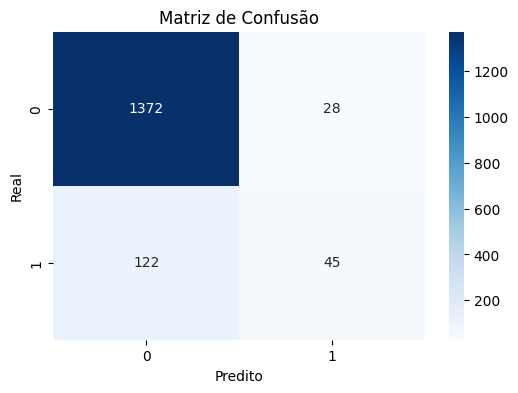

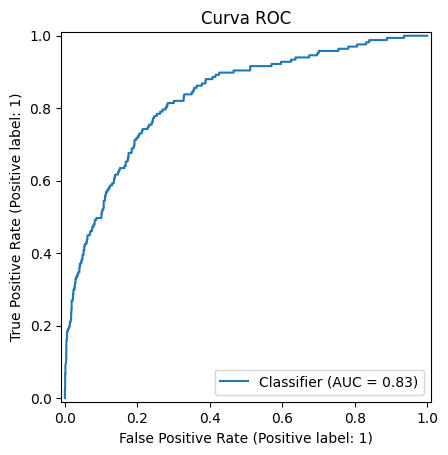

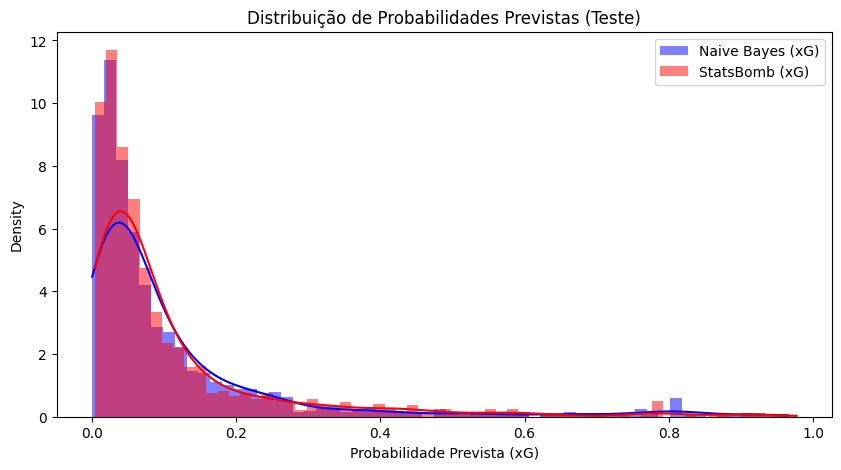

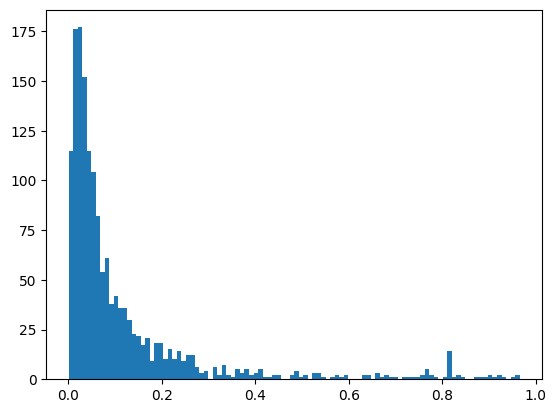

Min 0.0004185950622523012
Max 0.9654503954560195
Mean 0.11233129150362671


In [ ]:
pca = PCA(n_components=14)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 17 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.61      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0752


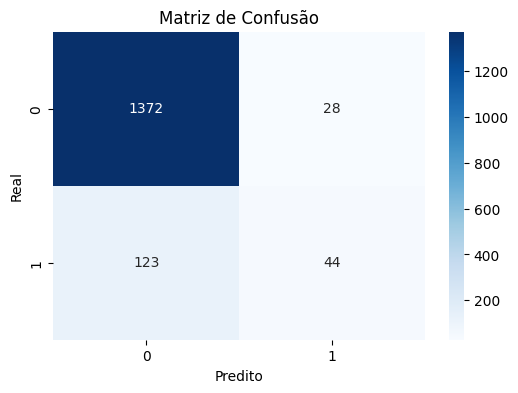

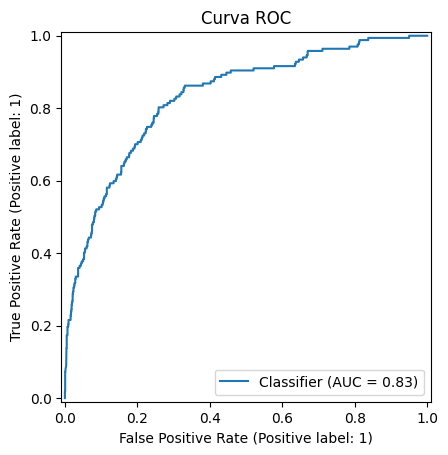

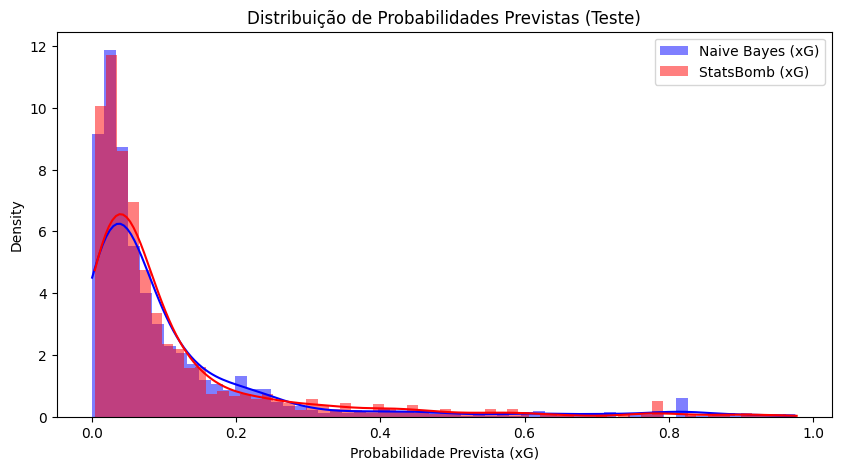

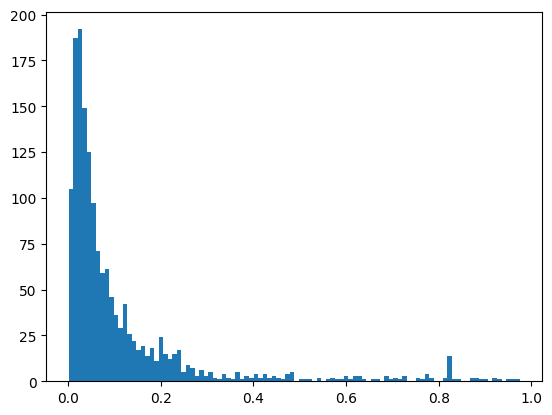

Min 0.0006508918442366577
Max 0.9748160646610542
Mean 0.11239930341850263


In [ ]:
pca = PCA(n_components=17)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 20 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.60      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.88      0.90      0.89      1567


Brier Score:  0.075


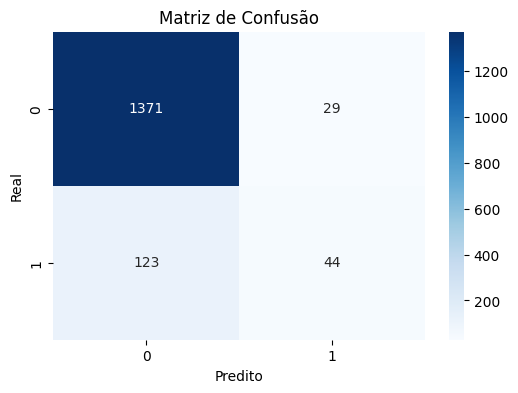

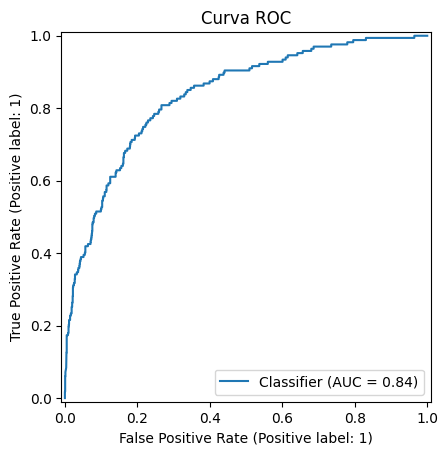

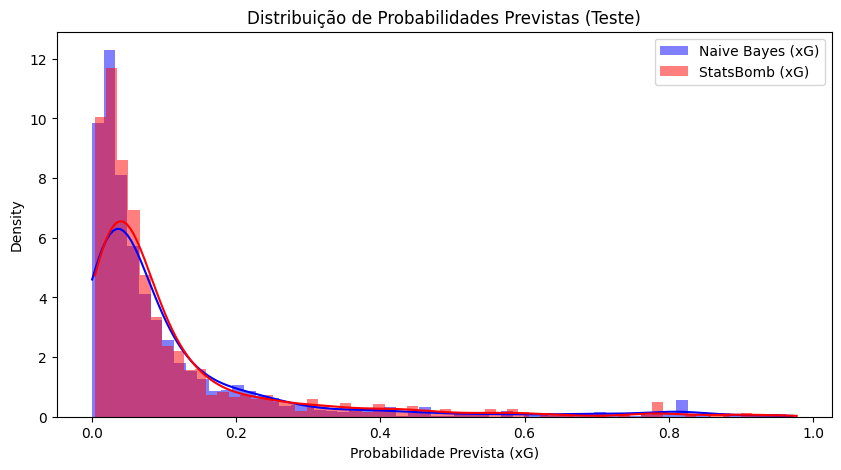

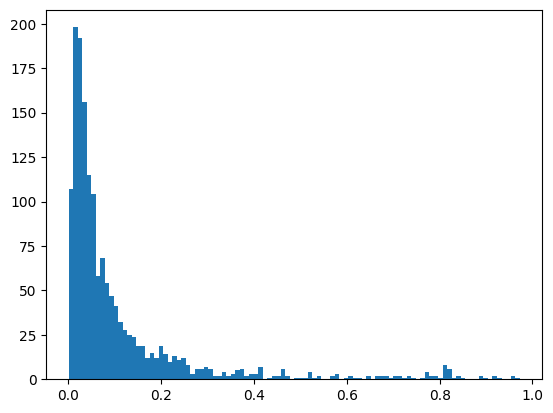

Min 0.00045660532779783684
Max 0.9721308989272959
Mean 0.11146627909675422


In [ ]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 23 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.60      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.88      0.90      0.89      1567


Brier Score:  0.075


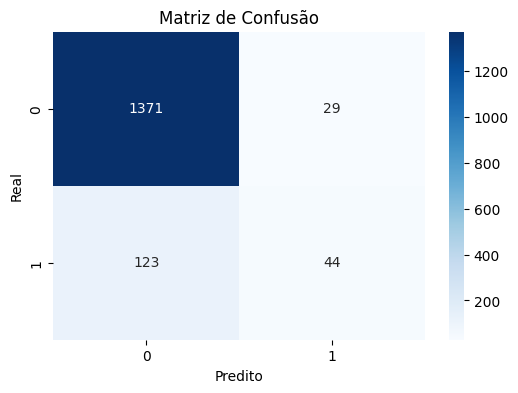

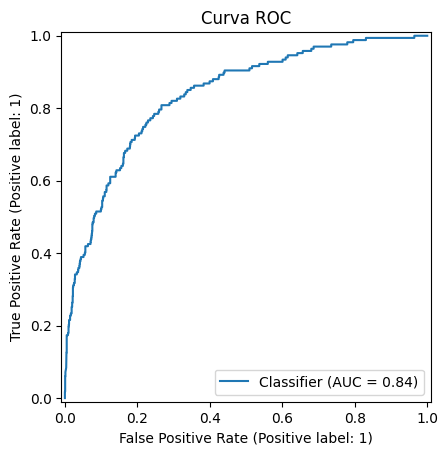

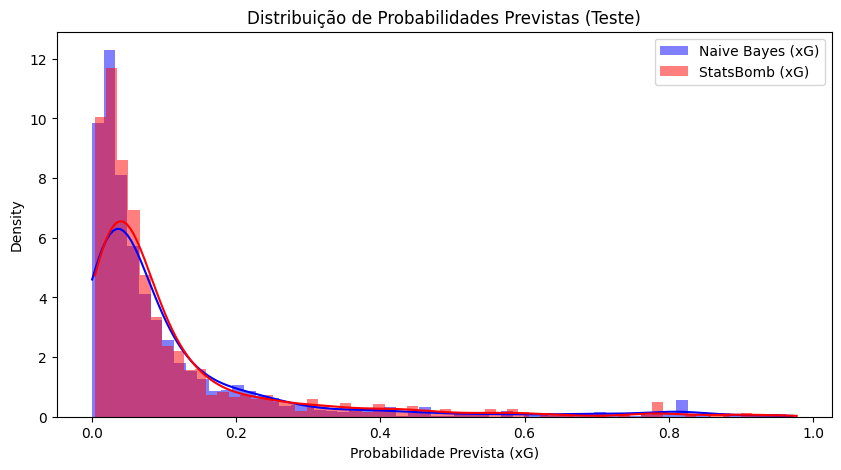

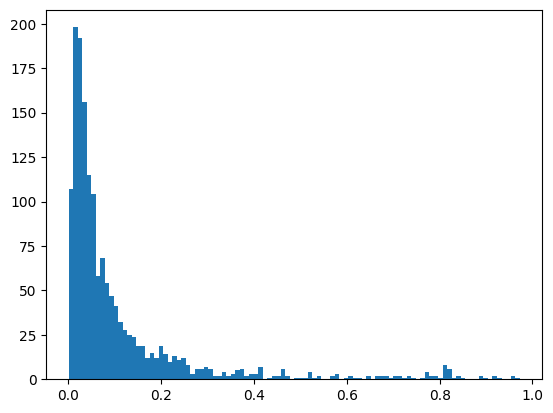

Min 0.00045660532779783684
Max 0.9721308989272959
Mean 0.11146627909675422


In [ ]:
pca = PCA(n_components=23)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## 27 Componentes


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.60      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.88      0.90      0.89      1567


Brier Score:  0.075


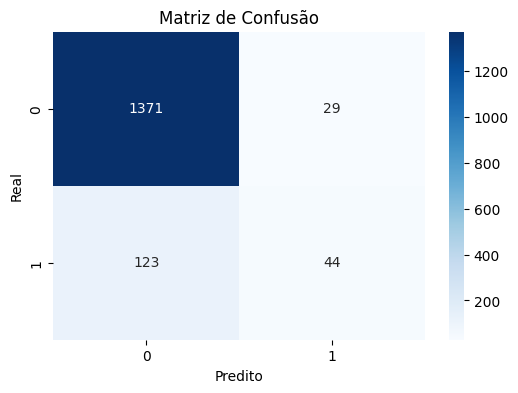

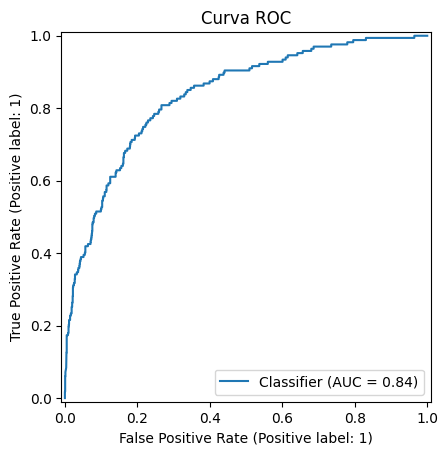

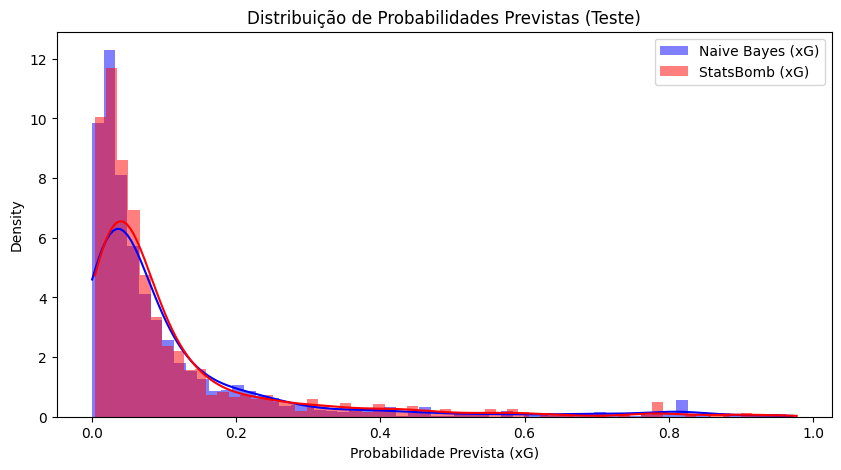

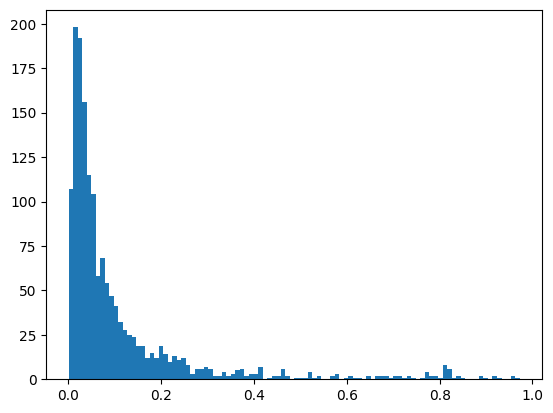

Min 0.00045660532779783684
Max 0.9721308989272959
Mean 0.11146627909675422


In [ ]:
pca = PCA(n_components=27)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression()
model.fit(X_train_pca, y_train)

result(X_test_pca, model)

## Análise das métricas em relação ao PCA

In [ ]:
max_components = X_train_scaled.shape[1]

resultados = []

for n_components in range(1, max_components + 1):
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    model = LogisticRegression()
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]

    resultados.append({
        "n_components": n_components,
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "recall": recall_score(y_test, y_pred),
        "brier": brier_score_loss(y_test, y_prob)
    })

results_df = pd.DataFrame(resultados)
results_df.head()

n_components  accuracy   roc_auc    recall     brier
0             1  0.893427  0.683839  0.000000  0.092628
1             2  0.906828  0.789861  0.173653  0.079661
2             3  0.902999  0.791555  0.149701  0.078826
3             4  0.902999  0.793886  0.155689  0.078448
4             5  0.905552  0.813364  0.179641  0.076504

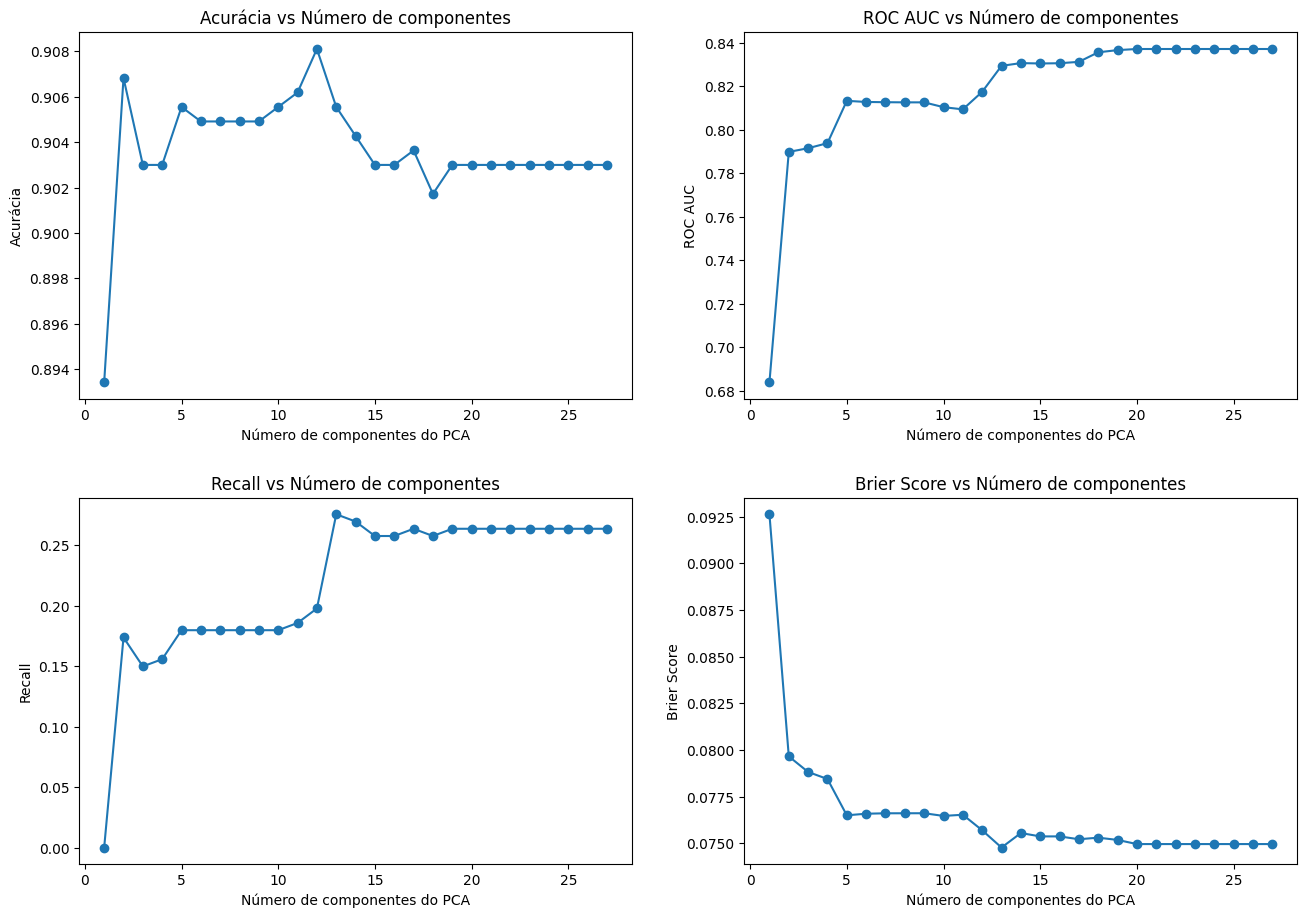

In [ ]:
results_df = pd.DataFrame(resultados, columns=["n_components", "accuracy", "roc_auc", "recall", "brier"])

# Criando uma grid de gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid para as 4 métricas
fig.tight_layout(pad=5.0)  # Ajuste do espaçamento

metrics = ["accuracy", "roc_auc", "recall", "brier"]
titles = ["Acurácia", "ROC AUC", "Recall", "Brier Score"]

for i, metric in enumerate(metrics):
    row = i // 2  # Calculando a linha (0 ou 1)
    col = i % 2   # Calculando a coluna (0 ou 1)

    axes[row, col].plot(results_df["n_components"], results_df[metric], marker='o')
    axes[row, col].set_xlabel("Número de componentes do PCA")
    axes[row, col].set_ylabel(titles[i])
    axes[row, col].set_title(f"{titles[i]} vs Número de componentes")

plt.show()

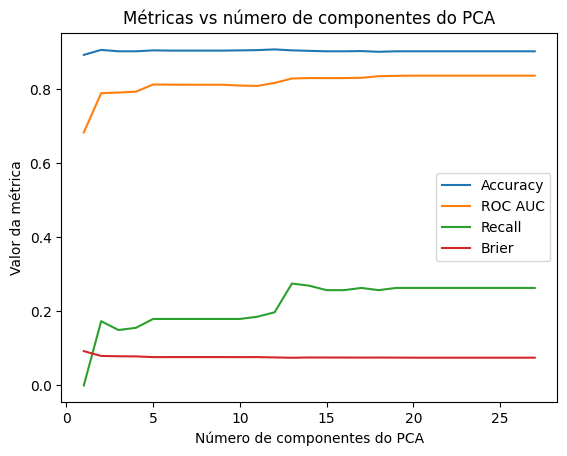

In [ ]:
results_plot = results_df.copy()

# Inverter Brier para manter interpretação "quanto maior, melhor"
results_plot["brier_inv"] = results_plot["brier"]

plt.figure()
plt.plot(results_plot["n_components"], results_plot["accuracy"], label="Accuracy")
plt.plot(results_plot["n_components"], results_plot["roc_auc"], label="ROC AUC")
plt.plot(results_plot["n_components"], results_plot["recall"], label="Recall")
plt.plot(results_plot["n_components"], results_plot["brier_inv"], label="Brier")

plt.xlabel("Número de componentes do PCA")
plt.ylabel("Valor da métrica")
plt.title("Métricas vs número de componentes do PCA")
plt.legend()
plt.show()


# Treinamento 3 - Otimização de Hiperparâmetros

## Maximização da Acurácia

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="accuracy", pca_method=False), n_trials=1000)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

# Treinando o modelo final
model.fit(X_train, y_train)

[I 2025-12-14 00:58:51,971] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-14 00:58:52,424] Trial 0 finished with value: 0.9036375239310785 and parameters: {'C': 0.5938520050266489, 'solver': 'lbfgs', 'max_iter': 682, 'penalty': 'l2', 'tol': 0.0038348908386870786}. Best is trial 0 with value: 0.9036375239310785.
[I 2025-12-14 00:58:52,605] Trial 1 finished with value: 0.9029993618379069 and parameters: {'C': 2518.8581743675854, 'solver': 'newton-cg', 'max_iter': 235, 'penalty': 'l2', 'tol': 0.00033942511133690717}. Best is trial 0 with value: 0.9036375239310785.
[I 2025-12-14 00:58:52,662] Trial 2 finished with value: 0.9087428206764518 and parameters: {'C': 118.60656034926059, 'solver': 'liblinear', 'max_iter': 127, 'penalty': 'l2', 'tol': 0.005755364940697836}. Best is trial 2 with value: 0.9087428206764518.
[I 2025-12-14 00:58:52,710] Trial 3 finished with value: 0.9017230376515635 and parameters: {'C': 0.9912363853224212, 'solver': 'liblinear', '

LogisticRegression(C=8057.7237845938325, max_iter=711, random_state=42,
                   solver='sag', tol=0.005407151655657566)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1400
           1       0.74      0.26      0.38       167

    accuracy                           0.91      1567
   macro avg       0.83      0.62      0.67      1567
weighted avg       0.90      0.91      0.89      1567


Brier Score:  0.0741


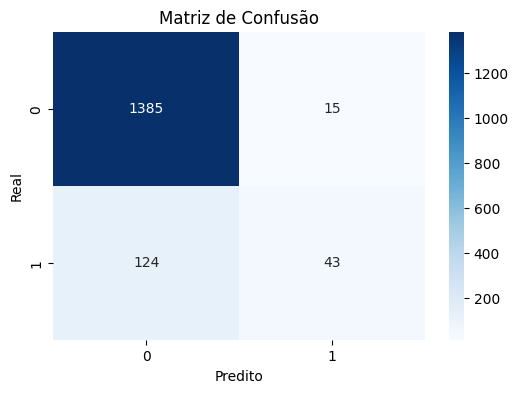

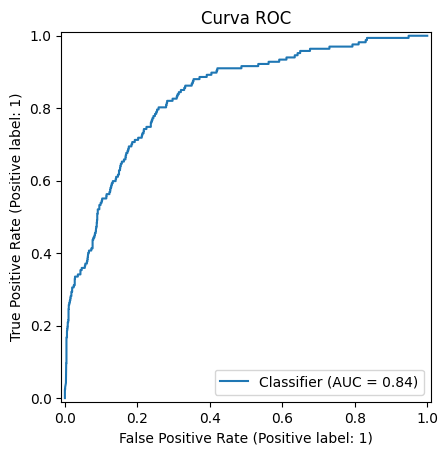

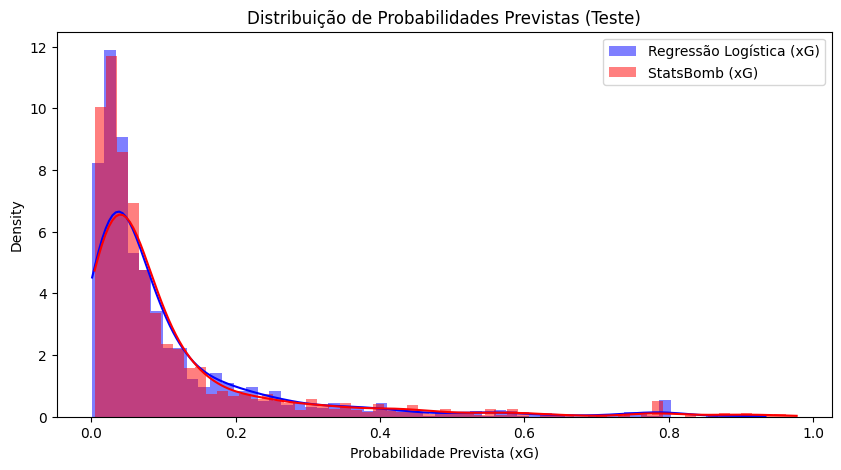

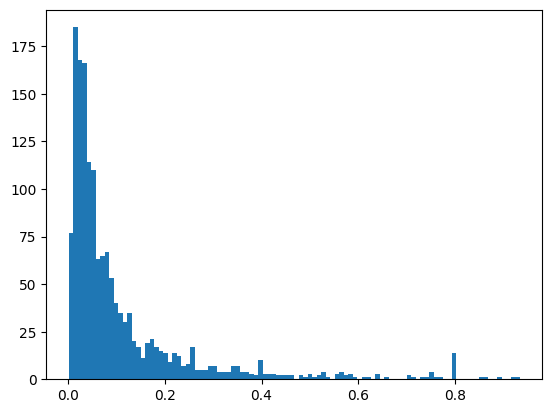

Min 0.000917135914855731
Max 0.9339744712231746
Mean 0.10926903492623886


In [ ]:
result(X_test, model)

## Maximização de AUC

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="auc", pca_method=False), n_trials=1000)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

# Treinando o modelo final
model.fit(X_train, y_train)

[I 2025-12-14 01:01:32,884] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-14 01:01:33,338] Trial 0 finished with value: 0.8349422583404619 and parameters: {'C': 0.09623441862583282, 'solver': 'saga', 'max_iter': 639, 'penalty': 'l2', 'tol': 0.005816541573894018}. Best is trial 0 with value: 0.8349422583404619.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-12-14 01:01:34,034] Trial 1 finished with value: 0.8361484174508127 and parameters: {'C': 2309.048453585078, 'solver': 'saga', 'max_iter': 198, 'penalty': 'l2', 'tol': 0.003840487471480905}. Best is trial 1 with value: 0.8361484174508127.
[I 2025-12-14 01:01:34,437] Trial 2 finished with value: 0.8349850299401198 and parameters: {'C': 7976.681675820443, 'solver': 'saga', 'max_iter': 157, 'penalty': 'l2', 'tol': 0.006561377215779112}. Best is trial 1 with value: 0.

LogisticRegression(C=1.9113120661288614, max_iter=942, random_state=42,
                   solver='sag', tol=0.0017755409929258083)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.68      0.27      0.39       167

    accuracy                           0.91      1567
   macro avg       0.80      0.63      0.67      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0744


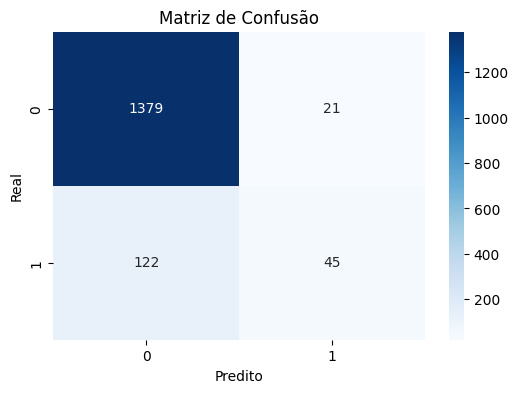

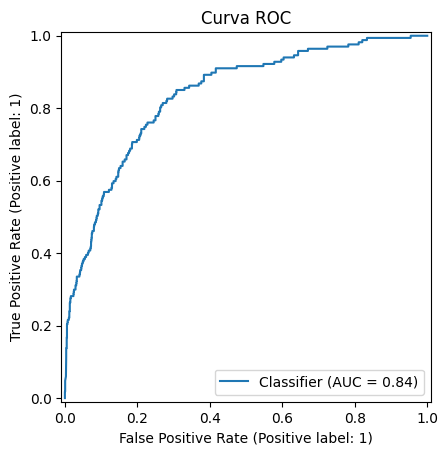

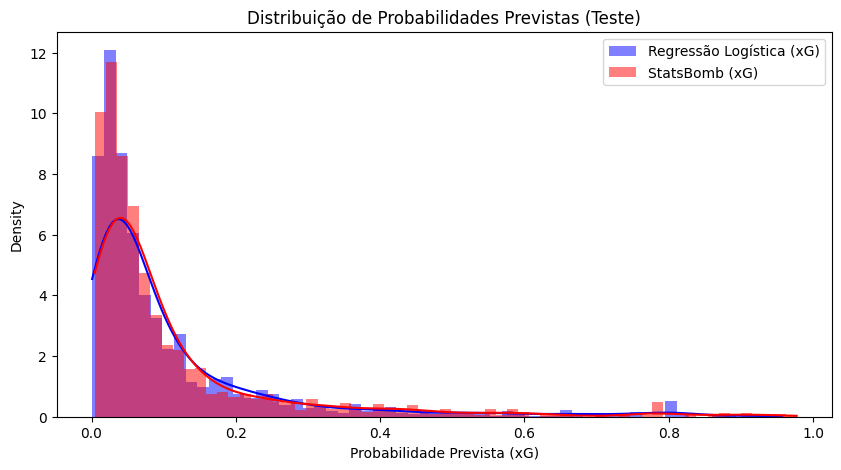

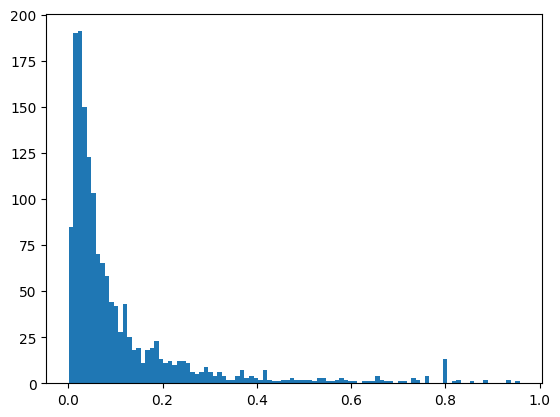

Min 0.0008155192472778871
Max 0.957336934455874
Mean 0.11061498681133755


In [ ]:
result(X_test, model)

## Maximização do Recall

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="recall", pca_method=False), n_trials=1000)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

# Treinando o modelo final
model.fit(X_train, y_train)

[I 2025-12-14 01:17:42,306] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-14 01:17:42,419] Trial 0 finished with value: 0.11976047904191617 and parameters: {'C': 5.362661298422031e-05, 'solver': 'lbfgs', 'max_iter': 490, 'penalty': 'l2', 'tol': 0.0021616787005038934}. Best is trial 0 with value: 0.11976047904191617.
[I 2025-12-14 01:17:42,510] Trial 1 finished with value: 0.1497005988023952 and parameters: {'C': 0.0009104068572741366, 'solver': 'newton-cg', 'max_iter': 635, 'penalty': 'l2', 'tol': 0.009124689603994493}. Best is trial 1 with value: 0.1497005988023952.
[I 2025-12-14 01:17:43,255] Trial 2 finished with value: 0.25748502994011974 and parameters: {'C': 0.9115323873129189, 'solver': 'sag', 'max_iter': 806, 'penalty': 'l2', 'tol': 0.005656362245856654}. Best is trial 2 with value: 0.25748502994011974.
[I 2025-12-14 01:17:44,421] Trial 3 finished with value: 0.2634730538922156 and parameters: {'C': 10589.564784113656, 'solver': 'sag', 'max_

LogisticRegression(C=783.6034276395751, max_iter=746, random_state=42,
                   solver='newton-cg', tol=0.0035247066194931476)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.61      0.28      0.38       167

    accuracy                           0.90      1567
   macro avg       0.77      0.63      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.075


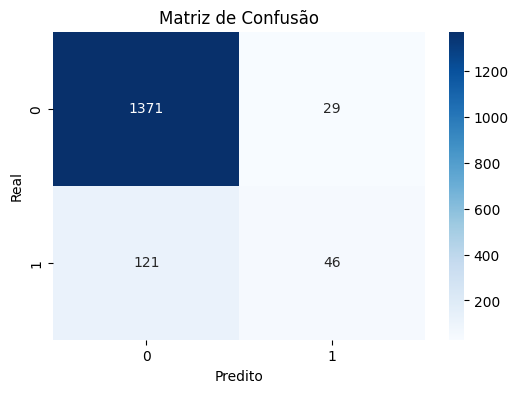

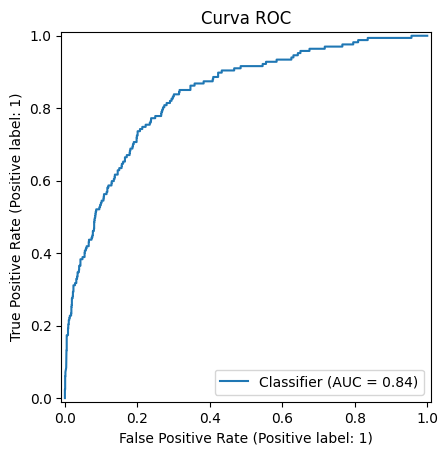

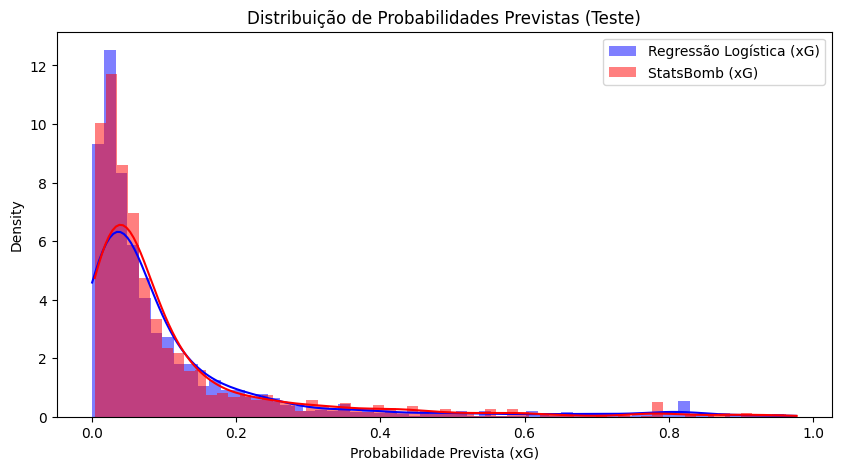

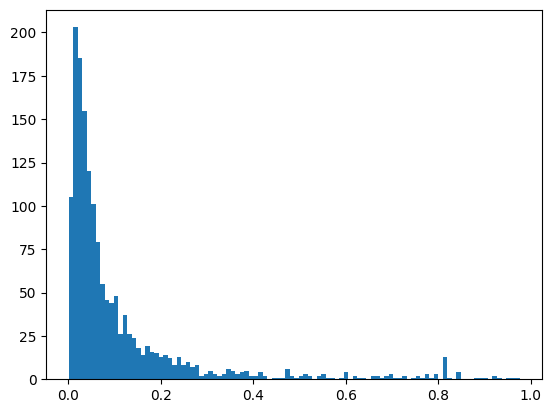

Min 0.000704143608250107
Max 0.975944539905373
Mean 0.11166153807943367


In [ ]:
result(X_test, model)

## Minimização do Brier Score

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="minimize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="brier_score", pca_method=False), n_trials=1000)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

# Treinando o modelo final
model.fit(X_train, y_train)

[I 2025-12-14 01:20:26,311] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-14 01:20:26,515] Trial 0 finished with value: 0.0751270754816517 and parameters: {'C': 0.04914938658885669, 'solver': 'saga', 'max_iter': 880, 'penalty': 'l2', 'tol': 0.009308299039798403}. Best is trial 0 with value: 0.0751270754816517.
[I 2025-12-14 01:20:26,565] Trial 1 finished with value: 0.07599226292742337 and parameters: {'C': 0.0020025644585540546, 'solver': 'newton-cg', 'max_iter': 943, 'penalty': 'l2', 'tol': 0.0012494582359262808}. Best is trial 0 with value: 0.0751270754816517.
[I 2025-12-14 01:20:26,623] Trial 2 finished with value: 0.08129889469162568 and parameters: {'C': 1.78479532443367e-05, 'solver': 'saga', 'max_iter': 553, 'penalty': 'l2', 'tol': 0.0011513906744771002}. Best is trial 0 with value: 0.0751270754816517.
[I 2025-12-14 01:20:26,658] Trial 3 finished with value: 0.07412088396330702 and parameters: {'C': 0.7153313831823221, 'solver': 'liblinear',

LogisticRegression(C=0.15160945020660746, max_iter=645, random_state=42,
                   solver='newton-cg', tol=0.00791944860666527)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1400
           1       0.71      0.27      0.39       167

    accuracy                           0.91      1567
   macro avg       0.82      0.63      0.67      1567
weighted avg       0.90      0.91      0.89      1567


Brier Score:  0.0739


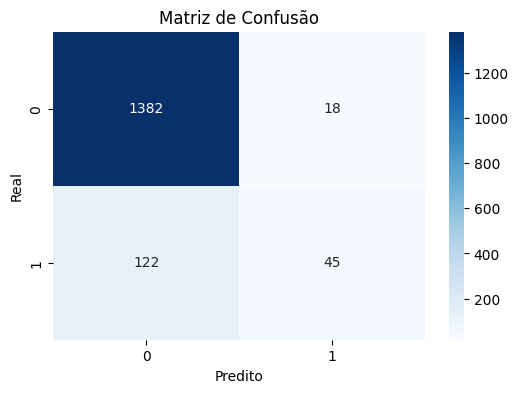

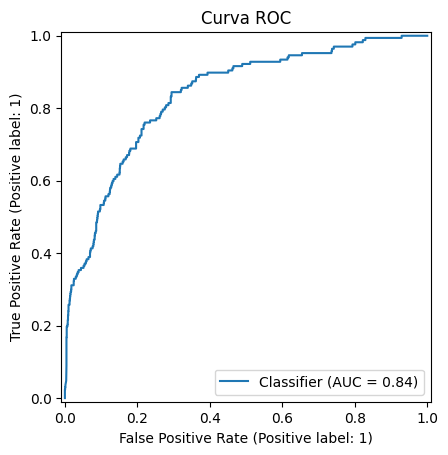

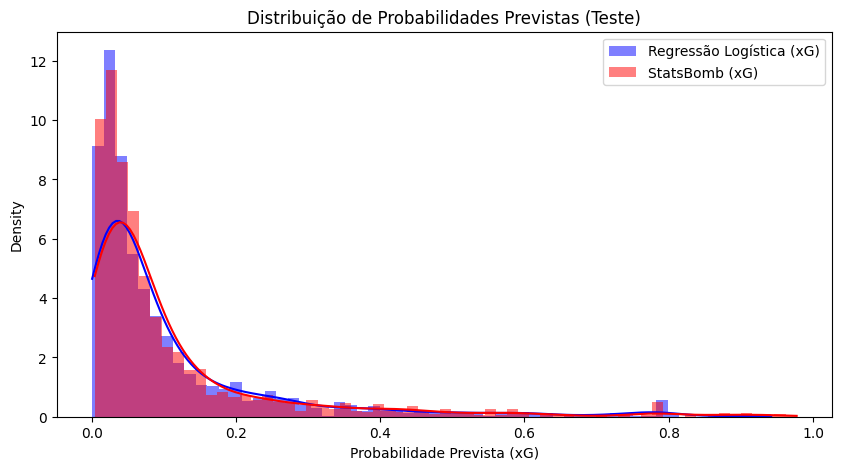

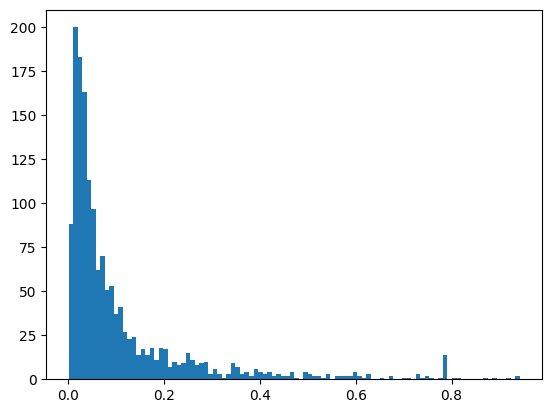

Min 0.0007713638569046553
Max 0.9419012899219497
Mean 0.10961912308474754


In [ ]:
result(X_test, model)

# Treinamento 4 - Otimização de Hiperparâmetros + PCA

## Maximização da Acurácia

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="accuracy", pca_method=True), n_trials=1000)

best_params = study.best_trial.params

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 23:53:57,109] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-13 23:53:57,287] Trial 0 finished with value: 0.9055520102105935 and parameters: {'C': 2538.5861570772176, 'solver': 'saga', 'max_iter': 617, 'penalty': 'l2', 'tol': 0.008149125398947117, 'n_components': 5}. Best is trial 0 with value: 0.9055520102105935.
[I 2025-12-13 23:53:57,337] Trial 1 finished with value: 0.9055520102105935 and parameters: {'C': 0.0015913258603059456, 'solver': 'newton-cg', 'max_iter': 435, 'penalty': 'l2', 'tol': 0.008487181060580112, 'n_components': 23}. Best is trial 0 with value: 0.9055520102105935.
[I 2025-12-13 23:53:57,408] Trial 2 finished with value: 0.8934269304403318 and parameters: {'C': 1.7630160357326473e-05, 'solver': 'sag', 'max_iter': 968, 'penalty': 'l2', 'tol': 0.003513605939764964, 'n_components': 21}. Best is trial 0 with value: 0.9055520102105935.
[I 2025-12-13 23:53:57,508] Trial 3 finished with value: 0.8934269304403318 and parame

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 LogisticRegression(C=1.532421137163611, max_iter=501,
                                    random_state=42, solver='saga',
                                    tol=0.0043203329941231584))])


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.77      0.20      0.31       167

    accuracy                           0.91      1567
   macro avg       0.84      0.60      0.63      1567
weighted avg       0.90      0.91      0.88      1567


Brier Score:  0.0757


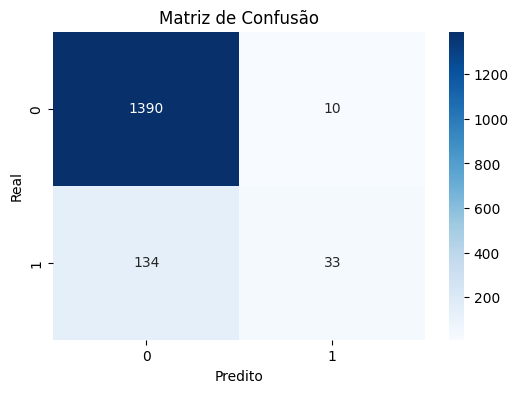

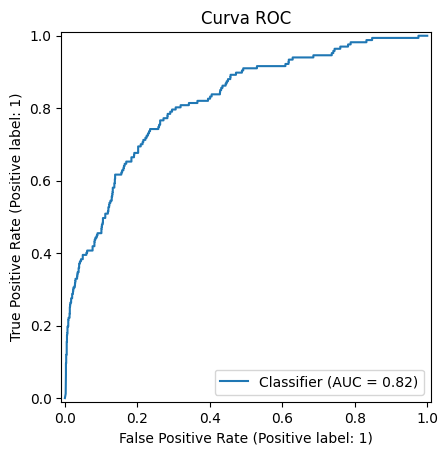

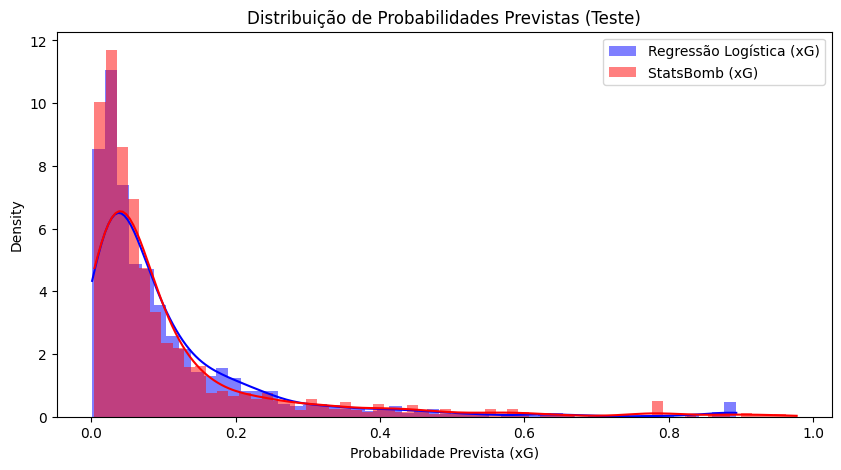

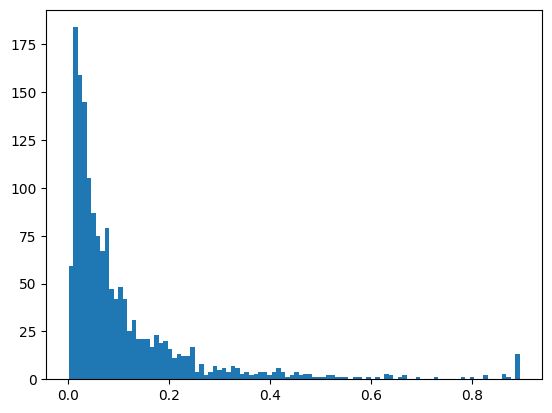

Min 0.0010945951924333475
Max 0.8935584441298227
Mean 0.10893076652852056


In [ ]:
result(X_test_pca, pipeline)

## Maximização do Auc

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="auc", pca_method=True), n_trials=1000)

best_params = study.best_trial.params

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 23:56:34,244] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-13 23:56:34,325] Trial 0 finished with value: 0.8306608212147134 and parameters: {'C': 15663.671502525192, 'solver': 'saga', 'max_iter': 657, 'penalty': 'l2', 'tol': 0.00991210218431297, 'n_components': 16}. Best is trial 0 with value: 0.8306608212147134.
[I 2025-12-13 23:56:34,369] Trial 1 finished with value: 0.8127352437981181 and parameters: {'C': 67.59802915486893, 'solver': 'liblinear', 'max_iter': 183, 'penalty': 'l2', 'tol': 0.008164606874367366, 'n_components': 7}. Best is trial 0 with value: 0.8306608212147134.
[I 2025-12-13 23:56:34,423] Trial 2 finished with value: 0.8128678357570572 and parameters: {'C': 56.48554916204227, 'solver': 'lbfgs', 'max_iter': 298, 'penalty': 'l2', 'tol': 0.007847439253213302, 'n_components': 7}. Best is trial 0 with value: 0.8306608212147134.
[I 2025-12-13 23:56:34,536] Trial 3 finished with value: 0.8377951240376389 and parameters: {'C

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 LogisticRegression(C=0.004131342808517773, max_iter=832,
                                    random_state=42,
                                    tol=0.00905537403892388))])


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.69      0.22      0.33       167

    accuracy                           0.91      1567
   macro avg       0.80      0.60      0.64      1567
weighted avg       0.89      0.91      0.88      1567


Brier Score:  0.0747


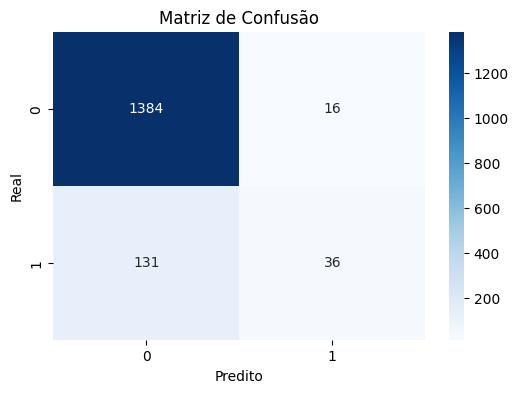

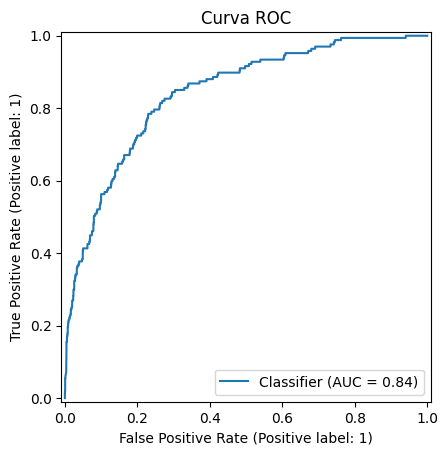

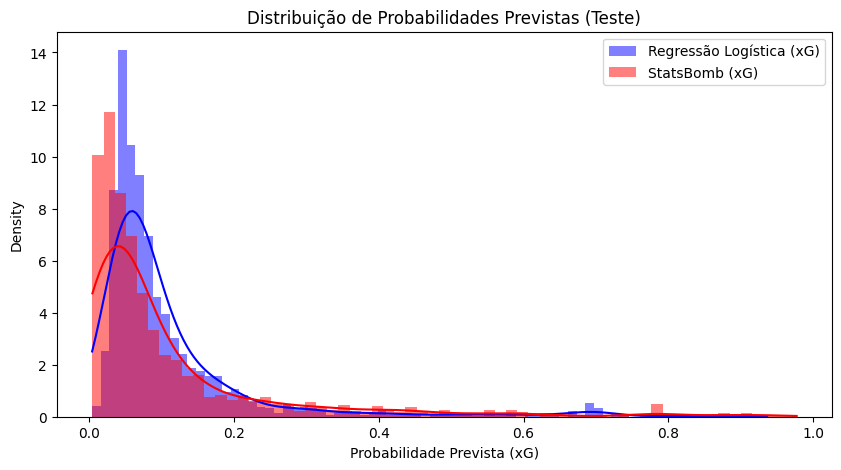

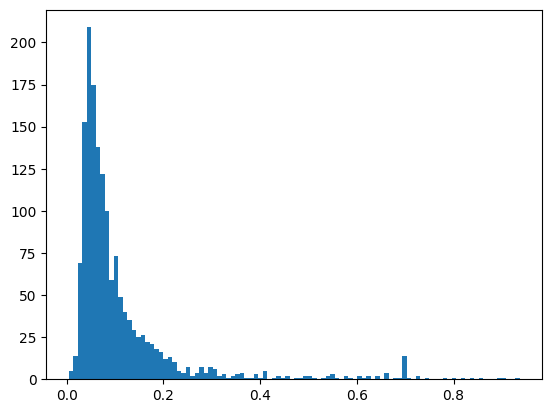

Min 0.0039933141977696145
Max 0.9364616089759531
Mean 0.11220244262136628


In [ ]:
result(X_test_pca, pipeline)

## Maximização do Recall

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="maximize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="recall", pca_method=True), n_trials=1000)

best_params = study.best_trial.params

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 23:58:49,818] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-13 23:58:49,854] Trial 0 finished with value: 0.15568862275449102 and parameters: {'C': 0.1373398819924656, 'solver': 'lbfgs', 'max_iter': 489, 'penalty': 'l2', 'tol': 0.002741583539824537, 'n_components': 4}. Best is trial 0 with value: 0.15568862275449102.
[I 2025-12-13 23:58:49,997] Trial 1 finished with value: 0.2634730538922156 and parameters: {'C': 8618.052569613787, 'solver': 'liblinear', 'max_iter': 274, 'penalty': 'l2', 'tol': 0.0077181697368334315, 'n_components': 21}. Best is trial 1 with value: 0.2634730538922156.
[I 2025-12-13 23:58:50,044] Trial 2 finished with value: 0.2634730538922156 and parameters: {'C': 6.964127727829673, 'solver': 'newton-cg', 'max_iter': 597, 'penalty': 'l2', 'tol': 0.0020447009456069903, 'n_components': 21}. Best is trial 1 with value: 0.2634730538922156.
[I 2025-12-13 23:58:50,156] Trial 3 finished with value: 0.25748502994011974 and par

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 LogisticRegression(C=1456.026527741656, max_iter=721,
                                    random_state=42, solver='liblinear',
                                    tol=0.00026127436521938396))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.63      0.28      0.38       167

    accuracy                           0.91      1567
   macro avg       0.77      0.63      0.67      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0748


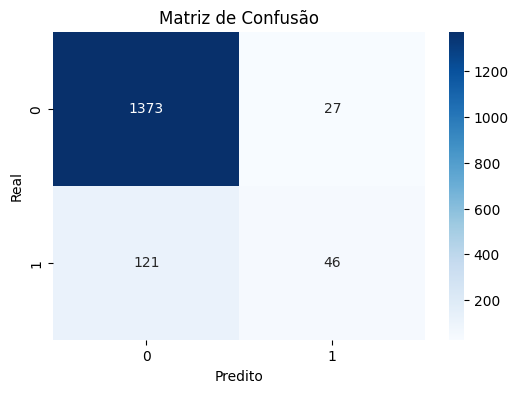

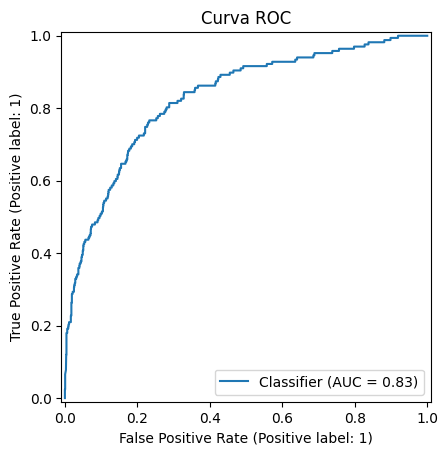

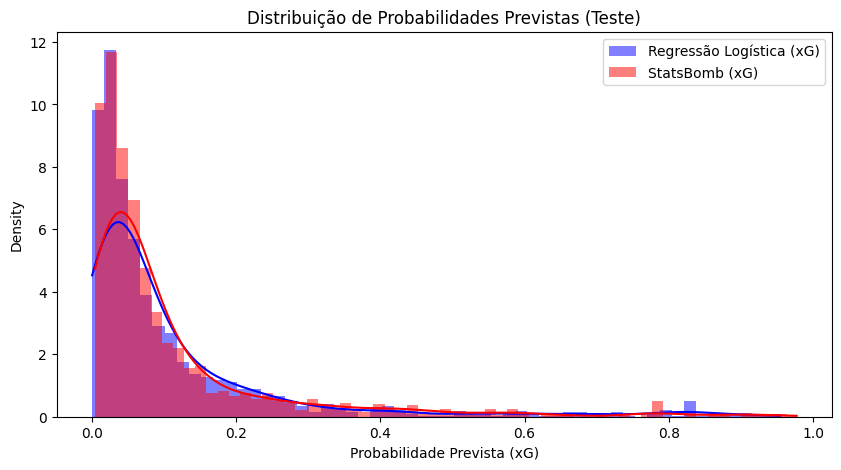

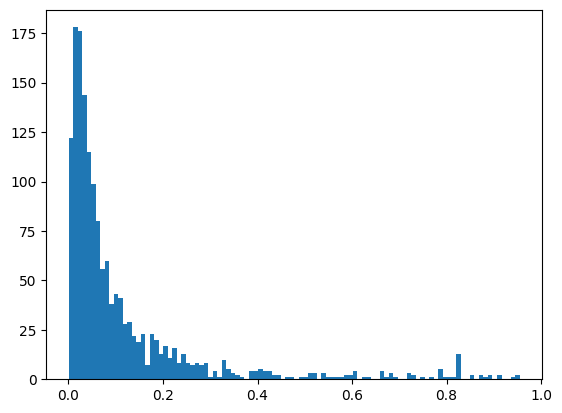

Min 0.00037802855648087563
Max 0.9544456434272106
Mean 0.1116132297778281


In [ ]:
result(X_test_pca, pipeline)

## Minimização do Brier Score

In [ ]:
study = optuna.create_study(
    study_name="LogisticRegression_xG_optimize",
    direction="minimize"
)

# Iniciando a otimização
study.optimize(partial(objective, metric="brier_score", pca_method=True), n_trials=1000)

best_params = study.best_trial.params

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Pegando os melhores parâmetros encontrados
best_params = study.best_trial.params

# Reconstruindo o modelo final com os melhores parâmetros
model = LogisticRegression(
    C=best_params["C"],
    solver=best_params["solver"],
    max_iter=best_params["max_iter"],
    penalty=best_params["penalty"],
    tol=best_params["tol"],
    random_state=42
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-14 00:00:56,284] A new study created in memory with name: LogisticRegression_xG_optimize
[I 2025-12-14 00:00:56,490] Trial 0 finished with value: 0.07493721496670873 and parameters: {'C': 140.9431489692805, 'solver': 'liblinear', 'max_iter': 293, 'penalty': 'l2', 'tol': 0.008078813611803397, 'n_components': 26}. Best is trial 0 with value: 0.07493721496670873.
[I 2025-12-14 00:00:56,635] Trial 1 finished with value: 0.2336268249459676 and parameters: {'C': 3.302081648967708e-05, 'solver': 'liblinear', 'max_iter': 905, 'penalty': 'l2', 'tol': 0.009264202464302995, 'n_components': 9}. Best is trial 0 with value: 0.07493721496670873.
[I 2025-12-14 00:00:56,746] Trial 2 finished with value: 0.07481319369353101 and parameters: {'C': 71.62831094330522, 'solver': 'newton-cg', 'max_iter': 533, 'penalty': 'l2', 'tol': 0.009690213937785781, 'n_components': 23}. Best is trial 2 with value: 0.07481319369353101.
[I 2025-12-14 00:00:56,985] Trial 3 finished with value: 0.07570332271959347

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 LogisticRegression(C=0.01766099594594157, max_iter=117,
                                    random_state=42,
                                    tol=0.007763666157287131))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.60      0.24      0.34       167

    accuracy                           0.90      1567
   macro avg       0.76      0.61      0.64      1567
weighted avg       0.88      0.90      0.88      1567


Brier Score:  0.0742


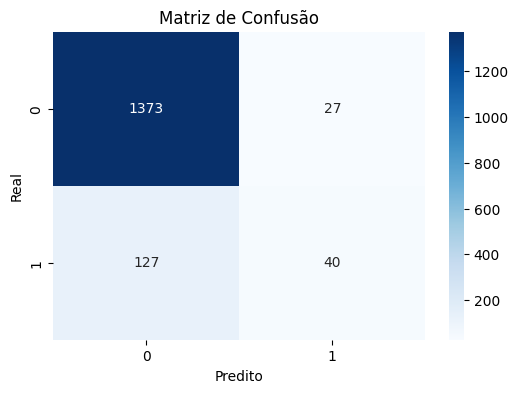

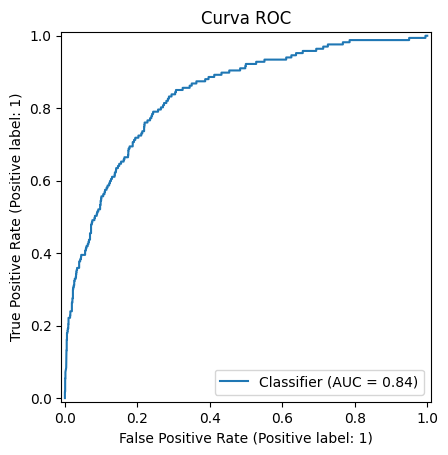

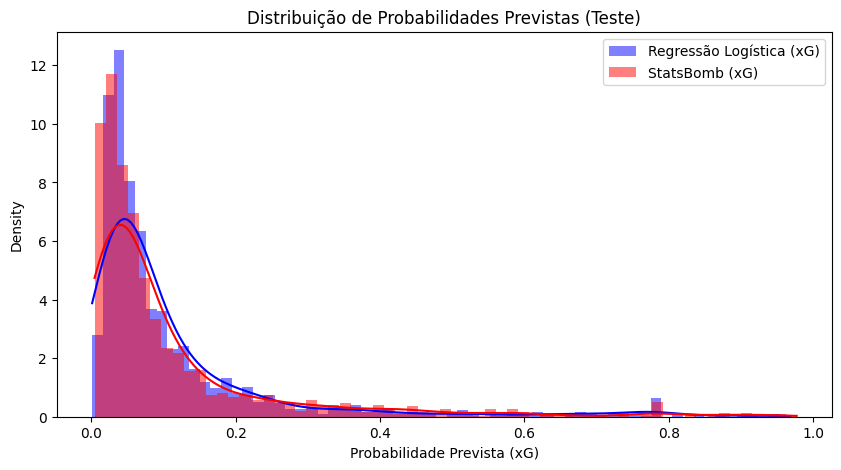

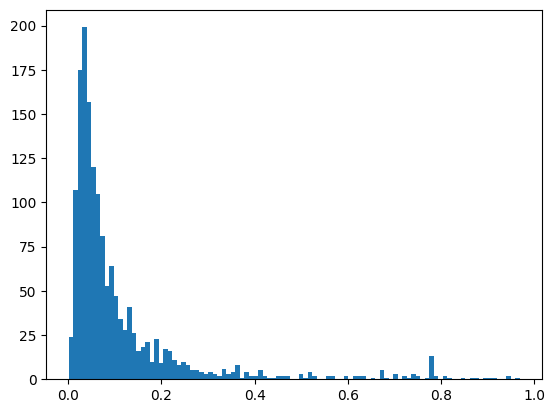

Min 0.0010556289624635159
Max 0.9683627987103203
Mean 0.11275222500758973


In [ ]:
result(X_test_pca, pipeline)